## Original HeteroGNN for Job Recommendations

This notebook implements the original heterogeneous graph neural network architecture from `enhanced_gnn_recommendation.py` for job recommendations. The model uses a combination of graph convolutional layers and attention mechanisms.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, HeteroData
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, Linear, HGTConv, GraphNorm, HeteroDictLinear
from torch_geometric.nn import TransformerConv, BatchNorm, to_hetero
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from sentence_transformers import SentenceTransformer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import os
import traceback

IN_KAGGLE = os.path.exists('/kaggle/input')

# Paths configuration
if IN_KAGGLE:
    # Kaggle paths
    BASE_PATH = '/kaggle/input'
    DATA_PATH = f'{BASE_PATH}/onet-data-filtered/filtered_IT_data.json'
    OUTPUT_PATH = '/kaggle/working'
else:
    # Local paths
    BASE_PATH = '.'
    DATA_PATH = 'filtered_IT_data.json'
    OUTPUT_PATH = '.'
    
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Graph Construction

In [2]:
# Load the JSON data
print("Loading job data...")
try:
    with open('filtered_IT_data.json', 'r') as f:
        data = json.load(f)
    print(f"Loaded data with {len(data)} job titles")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Initialize the job recommendation system


class HeteroJobRecommendationSystem:
    def __init__(self, data):
        self.data = data

        # Dictionaries for tracking entity mappings and relationships
        # Dictionary to store hotness score of each technology (0-1 scale)
        self.tech_hotness = {}
        # Dictionary to store demand score of each technology (0-1 scale)
        self.tech_demand = {}
        # Dictionary to store demand score of each job title (0-1 scale)
        self.job_demand = {}
        self.job_hot_tech_count = {}  # Dictionary to count hot technologies for each job

        # Create mappings for graph construction
        self.all_job_titles = []
        self.all_skills = []
        self.all_technologies = []

        # TF-IDF related counters
        self.skill_job_count = Counter()  # How many jobs require each skill
        self.tech_job_count = Counter()   # How many jobs require each technology
        self.job_skill_count = {}  # Number of skills per job
        self.job_tech_count = {}   # Number of technologies per job

        # Importance dictionaries
        self.skill_importance_by_job = {}  # Dict to store skill importance for each job
        # Dict to store technology importance for each job
        self.tech_importance_by_job = {}

        # Node and edge mappings
        self.job_skill_tech_map = {}  # Maps jobs to their skills and technologies

        # Processed data
        self.unique_job_titles = None
        self.unique_skills = None
        self.unique_technologies = None
        self.num_jobs = 0
        self.num_skills = 0
        self.num_techs = 0

        # Encoders
        self.job_encoder = None
        self.skill_encoder = None
        self.tech_encoder = None

        # IDF values
        self.skill_idf = None
        self.tech_idf = None

        # Graph data
        self.hetero_data = None
        self.node_types = None
        self.edge_types = None
        self.metadata = None

        # Feature embeddings
        self.job_tensor = None
        self.skill_tensor = None
        self.tech_tensor = None
        self.job_features = None
        self.skill_features = None
        self.tech_features = None

    def extract_metrics(self):
        """Extract demand and hotness metrics from the data"""
        print("Extracting technology hotness and demand metrics...")

        for job in tqdm(self.data):
            job_title = job['title']
            job_hot_techs = 0
            job_total_techs = 0
            tech_demand_scores = []

            for skill_data in job['technology_skills']:
                for tech in skill_data['technologies']:
                    tech_name = tech['name']
                    job_total_techs += 1

                    # Extract hot_tech_percentage and convert to float
                    try:
                        hot_tech_value = float(
                            tech.get('hot_tech_percentage', '0'))
                        # Convert to 0-1 scale
                        self.tech_hotness[tech_name] = hot_tech_value / 100.0
                        # Count as hot technology if hot_tech is "Yes"
                        if tech.get('hot_tech', 'No').lower() == 'yes':
                            job_hot_techs += 1
                    except (ValueError, TypeError):
                        self.tech_hotness[tech_name] = 0.0

                    # Extract demand_percentage and convert to float
                    try:
                        demand_value = float(
                            tech.get('demand_percentage', '0'))
                        # Convert to 0-1 scale
                        self.tech_demand[tech_name] = demand_value / 100.0
                        tech_demand_scores.append(demand_value / 100.0)
                    except (ValueError, TypeError):
                        self.tech_demand[tech_name] = 0.0

            # Calculate job demand as average of its technology demand scores
            if tech_demand_scores:
                self.job_demand[job_title] = sum(
                    tech_demand_scores) / len(tech_demand_scores)
            else:
                self.job_demand[job_title] = 0.0

            # Store the ratio of hot technologies for each job
            if job_total_techs > 0:
                self.job_hot_tech_count[job_title] = job_hot_techs / \
                    job_total_techs
            else:
                self.job_hot_tech_count[job_title] = 0.0

        print(
            f"Extracted hotness scores for {len(self.tech_hotness)} technologies")
        print(
            f"Extracted demand scores for {len(self.tech_demand)} technologies")
        print(
            f"Calculated demand scores for {len(self.job_demand)} job titles")

    def extract_entities(self):
        """Extract jobs, skills, and technologies from the data"""
        print("Extracting jobs, skills, and technologies...")

        for job in tqdm(self.data):
            job_title = job['title']
            self.all_job_titles.append(job_title)

            job_skills = set()  # Use set to avoid counting duplicates within a job
            job_techs = set()

            for skill_data in job['technology_skills']:
                skill_title = skill_data['skill_title']
                self.all_skills.append(skill_title)
                job_skills.add(skill_title)

                for tech in skill_data['technologies']:
                    tech_name = tech['name']
                    self.all_technologies.append(tech_name)
                    job_techs.add(tech_name)

            # Update counters
            for skill in job_skills:
                self.skill_job_count[skill] += 1

            for tech in job_techs:
                self.tech_job_count[tech] += 1

            self.job_skill_count[job_title] = len(job_skills)
            self.job_tech_count[job_title] = len(job_techs)

        # Remove duplicates
        self.unique_job_titles = list(set(self.all_job_titles))
        self.unique_skills = list(set(self.all_skills))
        self.unique_technologies = list(set(self.all_technologies))

        self.num_jobs = len(self.unique_job_titles)
        self.num_skills = len(self.unique_skills)
        self.num_techs = len(self.unique_technologies)

        print(f"Unique job titles: {self.num_jobs}")
        print(f"Unique skills: {self.num_skills}")
        print(f"Unique technologies: {self.num_techs}")

        # Define node and edge types for heterogeneous graph
        self.node_types = ['job', 'skill', 'tech']
        self.edge_types = [
            ('job', 'requires', 'skill'),
            ('skill', 'required_by', 'job'),
            ('skill', 'includes', 'tech'),
            ('tech', 'included_in', 'skill')
        ]
        self.metadata = (self.node_types, self.edge_types)

    def create_encoders(self):
        """Create label encoders for jobs, skills, and technologies"""
        print("Creating label encoders...")

        # Calculate IDF (Inverse Document Frequency) for skills and technologies
        total_jobs = len(self.unique_job_titles)
        self.skill_idf = {skill: np.log(total_jobs / (count + 1))
                          for skill, count in self.skill_job_count.items()}
        self.tech_idf = {tech: np.log(total_jobs / (count + 1))
                         for tech, count in self.tech_job_count.items()}

        # Create label encoders
        self.job_encoder = LabelEncoder()
        self.job_encoder.fit(self.unique_job_titles)

        self.skill_encoder = LabelEncoder()
        self.skill_encoder.fit(self.unique_skills)

        self.tech_encoder = LabelEncoder()
        self.tech_encoder.fit(self.unique_technologies)

    def generate_embeddings(self):
        """Generate embeddings for jobs, skills, and technologies"""
        print("Generating embeddings using Sentence Transformer...")

        # Get embedding dimension
        embedding_dim = sentence_transformer.get_sentence_embedding_dimension()
        print(f"Embedding dimension: {embedding_dim}")

        # Generate embeddings in batches
        print("Computing embeddings for jobs...")
        job_embeddings = sentence_transformer.encode(
            self.unique_job_titles, show_progress_bar=True)

        print("Computing embeddings for skills...")
        skill_embeddings = sentence_transformer.encode(
            self.unique_skills, show_progress_bar=True)

        print("Computing embeddings for technologies...")
        tech_embeddings = sentence_transformer.encode(
            self.unique_technologies, show_progress_bar=True)

        # Convert to torch tensors AND move to device
        self.job_tensor = torch.tensor(
            job_embeddings, dtype=torch.float).to(device)
        self.skill_tensor = torch.tensor(
            skill_embeddings, dtype=torch.float).to(device)
        self.tech_tensor = torch.tensor(
            tech_embeddings, dtype=torch.float).to(device)

        # Create embeddings from tensors
        self.job_features = nn.Embedding.from_pretrained(
            self.job_tensor, freeze=False)
        self.skill_features = nn.Embedding.from_pretrained(
            self.skill_tensor, freeze=False)
        self.tech_features = nn.Embedding.from_pretrained(
            self.tech_tensor, freeze=False)

    def build_graph(self):
        """Build the heterogeneous graph with nodes and edges"""
        print("Building the heterogeneous graph...")

        # Create a heterogeneous graph data structure
        hetero_data = HeteroData()

        # Add node features for each node type
        # For jobs, add base embedding features plus demand and hotness
        job_demand_features = torch.zeros(self.num_jobs, 1, device=device)
        job_hotness_features = torch.zeros(self.num_jobs, 1, device=device)

        # Fill in job demand and hotness values
        for job_title, job_id in zip(self.unique_job_titles, range(self.num_jobs)):
            job_demand_features[job_id, 0] = self.job_demand.get(
                job_title, 0.0)
            job_hotness_features[job_id, 0] = self.job_hot_tech_count.get(
                job_title, 0.0)

        # Concatenate base embeddings with demand and hotness for job nodes
        job_node_features = torch.cat(
            [self.job_tensor, job_demand_features, job_hotness_features], dim=1)

        # Add job node features to graph
        hetero_data['job'].x = job_node_features

        # For skills, add embeddings
        hetero_data['skill'].x = self.skill_tensor

        # For technologies, add embeddings, demand, and hotness
        tech_demand_features = torch.zeros(self.num_techs, 1, device=device)
        tech_hotness_features = torch.zeros(self.num_techs, 1, device=device)

        # Fill in technology demand and hotness values
        for tech_name, tech_id in zip(self.unique_technologies, range(self.num_techs)):
            tech_demand_features[tech_id,
                                 0] = self.tech_demand.get(tech_name, 0.0)
            tech_hotness_features[tech_id,
                                  0] = self.tech_hotness.get(tech_name, 0.0)

        # Concatenate base embeddings with demand and hotness for tech nodes
        tech_node_features = torch.cat(
            [self.tech_tensor, tech_demand_features, tech_hotness_features], dim=1)

        # Add tech node features to graph
        hetero_data['tech'].x = tech_node_features

        # Create the edge indices and edge attributes for each edge type
        job_to_skill_edges = []
        skill_to_job_edges = []
        skill_to_tech_edges = []
        tech_to_skill_edges = []

        # Edge attributes for different relation types
        job_skill_weights = []
        skill_job_weights = []
        skill_tech_weights = []
        tech_skill_weights = []

        # Edge features for heterogeneous edges
        job_skill_features = []
        skill_tech_features = []

        # Track which skills and technologies are associated with each job
        for job in tqdm(self.data):
            job_title = job['title']
            job_id = self.job_encoder.transform([job_title])[0]

            if job_title not in self.job_skill_tech_map:
                self.job_skill_tech_map[job_title] = {
                    'skills': set(), 'technologies': set()}
                self.skill_importance_by_job[job_title] = {}
                self.tech_importance_by_job[job_title] = {}

            # Count skill and tech occurrences within this job
            job_skill_count_local = Counter()
            job_tech_count_local = Counter()

            for skill_data in job['technology_skills']:
                skill_title = skill_data['skill_title']
                skill_id = self.skill_encoder.transform([skill_title])[0]

                # Add job-skill edge
                job_to_skill_edges.append((job_id, skill_id))
                skill_to_job_edges.append((skill_id, job_id))

                # Calculate edge weight using TF-IDF
                skill_idf_value = self.skill_idf.get(skill_title, 1.0)
                job_skill_weights.append(skill_idf_value)
                skill_job_weights.append(skill_idf_value)

                # Add edge feature (TF-IDF) as a tensor
                job_skill_features.append([skill_idf_value])

                self.job_skill_tech_map[job_title]['skills'].add(skill_title)
                job_skill_count_local[skill_title] += 1

                for tech in skill_data['technologies']:
                    tech_name = tech['name']
                    tech_id = self.tech_encoder.transform([tech_name])[0]

                    # Get hotness and demand values for this tech
                    tech_hotness_value = self.tech_hotness.get(tech_name, 0.0)
                    tech_demand_value = self.tech_demand.get(tech_name, 0.0)

                    # Add skill-tech edge
                    skill_to_tech_edges.append((skill_id, tech_id))
                    tech_to_skill_edges.append((tech_id, skill_id))

                    # Calculate edge weight using TF-IDF
                    tech_idf_value = self.tech_idf.get(tech_name, 1.0)
                    skill_tech_weights.append(tech_idf_value)
                    tech_skill_weights.append(tech_idf_value)

                    # Add edge feature as a tensor (TF-IDF, hotness, demand)
                    skill_tech_features.append(
                        [tech_idf_value, tech_hotness_value, tech_demand_value])

                    self.job_skill_tech_map[job_title]['technologies'].add(
                        tech_name)
                    job_tech_count_local[tech_name] += 1

            # Calculate skill importance for this job using TF-IDF
            for skill, count in job_skill_count_local.items():
                # Term frequency
                skill_tf = count / max(len(job_skill_count_local), 1)
                self.skill_importance_by_job[job_title][skill] = skill_tf * \
                    self.skill_idf.get(skill, 1.0)

            # Calculate technology importance for this job using TF-IDF
            for tech, count in job_tech_count_local.items():
                # Term frequency
                tech_tf = count / max(len(job_tech_count_local), 1)
                self.tech_importance_by_job[job_title][tech] = tech_tf * \
                    self.tech_idf.get(tech, 1.0)

        # Convert edge indices to tensors and add to heterogeneous data
        if job_to_skill_edges:
            job_to_skill = torch.tensor(
                job_to_skill_edges, dtype=torch.long).t().contiguous().to(device)
            skill_to_job = torch.tensor(
                skill_to_job_edges, dtype=torch.long).t().contiguous().to(device)

            # Add edges to the graph
            hetero_data[('job', 'requires', 'skill')].edge_index = job_to_skill
            hetero_data[('skill', 'required_by', 'job')
                        ].edge_index = skill_to_job

            # Add edge attributes
            job_skill_attr = torch.tensor(
                job_skill_features, dtype=torch.float).to(device)
            hetero_data[('job', 'requires', 'skill')
                        ].edge_attr = job_skill_attr
            skill_job_attr = torch.tensor(
                [[w] for w in skill_job_weights], dtype=torch.float).to(device)
            hetero_data[('skill', 'required_by', 'job')
                        ].edge_attr = skill_job_attr

        if skill_to_tech_edges:
            skill_to_tech = torch.tensor(
                skill_to_tech_edges, dtype=torch.long).t().contiguous().to(device)
            tech_to_skill = torch.tensor(
                tech_to_skill_edges, dtype=torch.long).t().contiguous().to(device)

            # Add edges to the graph
            hetero_data[('skill', 'includes', 'tech')
                        ].edge_index = skill_to_tech
            hetero_data[('tech', 'included_in', 'skill')
                        ].edge_index = tech_to_skill

            # Add edge attributes
            skill_tech_attr = torch.tensor(
                skill_tech_features, dtype=torch.float).to(device)
            hetero_data[('skill', 'includes', 'tech')
                        ].edge_attr = skill_tech_attr
            tech_skill_attr = torch.tensor(
                [[w] for w in tech_skill_weights], dtype=torch.float).to(device)
            hetero_data[('tech', 'included_in', 'skill')
                        ].edge_attr = tech_skill_attr

        # Create train/val split for job nodes
        num_train = int(0.8 * self.num_jobs)
        train_mask = torch.zeros(self.num_jobs, dtype=torch.bool).to(device)
        val_mask = torch.zeros(self.num_jobs, dtype=torch.bool).to(device)

        # Random split
        perm = torch.randperm(self.num_jobs).to(device)
        train_idx = perm[:num_train]
        val_idx = perm[num_train:]

        train_mask[train_idx] = True
        val_mask[val_idx] = True

        # Add masks and labels to job nodes
        hetero_data['job'].train_mask = train_mask
        hetero_data['job'].val_mask = val_mask
        hetero_data['job'].y = torch.arange(
            self.num_jobs).to(device)  # Self-supervision

        # Create bidirectional connections within the same node type for message passing
        # This helps with information flow in the graph
        self.hetero_data = hetero_data

        print(
            f"Created heterogeneous graph with node types: {self.hetero_data.node_types}")
        print(f"Edge types: {self.hetero_data.edge_types}")
        for edge_type in self.hetero_data.edge_types:
            print(
                f"  {edge_type}: {self.hetero_data[edge_type].edge_index.size(1)} edges")

        return hetero_data

    def process_data(self):
        """Process all data and build the graph"""
        self.extract_metrics()
        self.extract_entities()
        self.create_encoders()
        self.generate_embeddings()
        return self.build_graph()
# Load the Sentence Transformer model
print("Loading Sentence Transformer model...")
model_name = "sentence-transformers/msmarco-distilbert-base-v4"
sentence_transformer = SentenceTransformer(model_name)
print(f"Loaded {model_name}")

# Initialize the job recommendation system
system = HeteroJobRecommendationSystem(data)

# Process data and build graph
hetero_data = system.process_data()

# Get embedding dimension for model initialization
emb_dim = system.job_tensor.shape[1]

Loading job data...
Loaded data with 38 job titles
Loading Sentence Transformer model...
Loaded sentence-transformers/msmarco-distilbert-base-v4
Starting heterogeneous GNN-based job recommendation system...
Extracting technology hotness and demand metrics...


100%|██████████| 38/38 [00:00<00:00, 7838.66it/s]


Extracted hotness scores for 738 technologies
Extracted demand scores for 738 technologies
Calculated demand scores for 38 job titles
Extracting jobs, skills, and technologies...


100%|██████████| 38/38 [00:00<00:00, 11023.14it/s]


Unique job titles: 38
Unique skills: 128
Unique technologies: 738
Creating label encoders...
Generating embeddings using Sentence Transformer...
Embedding dimension: 768
Computing embeddings for jobs...


Computing embeddings for skills...


Computing embeddings for technologies...


Building the heterogeneous graph...


100%|██████████| 38/38 [00:03<00:00, 11.99it/s]


Created heterogeneous graph with node types: ['job', 'skill', 'tech']
Edge types: [('job', 'requires', 'skill'), ('skill', 'required_by', 'job'), ('skill', 'includes', 'tech'), ('tech', 'included_in', 'skill')]
  ('job', 'requires', 'skill'): 1934 edges
  ('skill', 'required_by', 'job'): 1934 edges
  ('skill', 'includes', 'tech'): 5091 edges
  ('tech', 'included_in', 'skill'): 5091 edges


# Models Architectures



## First: 

The model uses a Transformer-based architecture with the following components:
- Multi-head attention for node feature aggregation
- Edge feature processing with attention
- Hierarchical pooling for graph-level representations


In [ ]:
class TransformerHeteroGNN(nn.Module):
    def __init__(self, num_jobs, num_skills, num_techs, embedding_dim, edge_dim=3, hidden_dim=256):
        super(TransformerHeteroGNN, self).__init__()

        self.embedding_dim = embedding_dim + 2
        self.edge_dim = edge_dim
        self.hidden_dim = hidden_dim

        # Edge feature processing
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        # Transformer layers with increasing heads
        self.conv1 = TransformerConv(
            self.embedding_dim, hidden_dim, heads=4, edge_dim=edge_dim)
        self.conv2 = TransformerConv(
            hidden_dim * 4, hidden_dim, heads=8, edge_dim=edge_dim)
        self.conv3 = TransformerConv(
            hidden_dim * 8, hidden_dim, heads=4, edge_dim=edge_dim)

        # Batch normalization
        self.batch_norm1 = BatchNorm(hidden_dim * 4)
        self.batch_norm2 = BatchNorm(hidden_dim * 8)
        self.batch_norm3 = BatchNorm(hidden_dim * 4)

        # Output layers
        self.job_classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_jobs)
        )

        # Auxiliary tasks
        self.demand_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.hotness_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_attr=None):
        # Initial graph convolution
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = self.leaky_relu(x)
        x = self.batch_norm1(x)
        x = self.dropout(x)

        # Second graph convolution
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        x = self.leaky_relu(x)
        x = self.batch_norm2(x)
        x = self.dropout(x)

        # Third graph convolution
        x = self.conv3(x, edge_index, edge_attr=edge_attr)
        x = self.leaky_relu(x)
        x = self.batch_norm3(x)
        x = self.dropout(x)

        # Get job node embeddings
        job_embeddings = x[:self.num_jobs]

        # Predict job classes
        job_logits = self.job_classifier(job_embeddings)

        # Predict demand and hotness
        demand_scores = self.demand_predictor(job_embeddings)
        hotness_scores = self.hotness_predictor(job_embeddings)

        return job_logits, demand_scores, hotness_scores

## Second :

The model uses a GraphSAGE-based architecture with the following components:
- Hierarchical neighborhood sampling
- Mean aggregation for node features
- Residual connections for better gradient flow


In [ ]:
class GraphSAGEHeteroGNN(nn.Module):
    def __init__(self, num_jobs, num_skills, num_techs, embedding_dim, edge_dim=3, hidden_dim=256):
        super(GraphSAGEHeteroGNN, self).__init__()

        self.embedding_dim = embedding_dim + 2
        self.edge_dim = edge_dim
        self.hidden_dim = hidden_dim

        # Edge feature processing
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        # GraphSAGE layers with residual connections
        self.conv1 = SAGEConv(self.embedding_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)

        # Batch normalization
        self.batch_norm1 = BatchNorm(hidden_dim)
        self.batch_norm2 = BatchNorm(hidden_dim)
        self.batch_norm3 = BatchNorm(hidden_dim)

        # Output layers
        self.job_classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 4, num_jobs)
        )

        # Auxiliary tasks
        self.demand_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

        self.hotness_predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_attr=None):
        # Initial graph convolution
        x1 = self.conv1(x, edge_index)
        x1 = self.leaky_relu(x1)
        x1 = self.batch_norm1(x1)
        x1 = self.dropout(x1)

        # Second graph convolution with residual
        x2 = self.conv2(x1, edge_index)
        x2 = self.leaky_relu(x2)
        x2 = self.batch_norm2(x2)
        x2 = self.dropout(x2)
        x2 = x2 + x1  # Residual connection

        # Third graph convolution with residual
        x3 = self.conv3(x2, edge_index)
        x3 = self.leaky_relu(x3)
        x3 = self.batch_norm3(x3)
        x3 = self.dropout(x3)
        x3 = x3 + x2  # Residual connection

        # Get job node embeddings
        job_embeddings = x3[:self.num_jobs]

        # Predict job classes
        job_logits = self.job_classifier(job_embeddings)

        # Predict demand and hotness
        demand_scores = self.demand_predictor(job_embeddings)
        hotness_scores = self.hotness_predictor(job_embeddings)

        return job_logits, demand_scores, hotness_scores

## Third :

The model uses a GAT-based architecture with the following components:
- Multi-head attention mechanisms
- Edge feature integration
- Residual connections for better gradient flow


In [ ]:
class GATHeteroGNN(nn.Module):
    def __init__(self, num_jobs, num_skills, num_techs, embedding_dim, edge_dim=3, hidden_dim=256):
        super(GATHeteroGNN, self).__init__()

        self.embedding_dim = embedding_dim + 2
        self.edge_dim = edge_dim
        self.hidden_dim = hidden_dim

        # Edge feature processing
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        # GAT layers with increasing heads
        self.conv1 = GATConv(self.embedding_dim, hidden_dim,
                             heads=4, edge_dim=edge_dim)
        self.conv2 = GATConv(hidden_dim * 4, hidden_dim,
                             heads=8, edge_dim=edge_dim)
        self.conv3 = GATConv(hidden_dim * 8, hidden_dim,
                             heads=4, edge_dim=edge_dim)

        # Batch normalization
        self.batch_norm1 = BatchNorm(hidden_dim * 4)
        self.batch_norm2 = BatchNorm(hidden_dim * 8)
        self.batch_norm3 = BatchNorm(hidden_dim * 4)

        # Output layers
        self.job_classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_jobs)
        )

        # Auxiliary tasks
        self.demand_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.hotness_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_attr=None):
        # Initial graph convolution
        x1 = self.conv1(x, edge_index, edge_attr=edge_attr)
        x1 = self.leaky_relu(x1)
        x1 = self.batch_norm1(x1)
        x1 = self.dropout(x1)

        # Second graph convolution with skip connection
        x2 = self.conv2(x1, edge_index, edge_attr=edge_attr)
        x2 = self.leaky_relu(x2)
        x2 = self.batch_norm2(x2)
        x2 = self.dropout(x2)
        x2 = x2 + x1  # Skip connection

        # Third graph convolution with skip connection
        x3 = self.conv3(x2, edge_index, edge_attr=edge_attr)
        x3 = self.leaky_relu(x3)
        x3 = self.batch_norm3(x3)
        x3 = self.dropout(x3)
        x3 = x3 + x2  # Skip connection

        # Get job node embeddings
        job_embeddings = x3[:self.num_jobs]

        # Predict job classes
        job_logits = self.job_classifier(job_embeddings)

        # Predict demand and hotness
        demand_scores = self.demand_predictor(job_embeddings)
        hotness_scores = self.hotness_predictor(job_embeddings)

        return job_logits, demand_scores, hotness_scores

## Last :

The model uses the exact architecture from enhanced_gnn_recommendation.py with the following components:
- Transformer-based graph convolutions
- Edge feature processing
- Batch normalization and dropout for regularization

In [2]:
class EnhancedGNNJobRecommender(nn.Module):
    def __init__(self, num_jobs, num_skills, num_techs, embedding_dim, edge_dim=3, hidden_dim=256):
        super(EnhancedGNNJobRecommender, self).__init__()

        # Adjusted embedding dimension to account for added demand and hotness features
        self.embedding_dim = embedding_dim + 2  # +2 for demand and hotness
        self.edge_dim = edge_dim  # weight, hotness, demand
        self.hidden_dim = hidden_dim
        self.num_jobs = num_jobs
        self.num_skills = num_skills
        self.num_techs = num_techs

        # Edge feature processing
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        # Graph convolutional layers with edge feature processing
        self.conv1 = TransformerConv(
            self.embedding_dim, hidden_dim, heads=4, edge_dim=edge_dim)
        self.conv2 = TransformerConv(
            hidden_dim * 4, hidden_dim, heads=4, edge_dim=edge_dim)
        self.conv3 = TransformerConv(
            hidden_dim * 4, hidden_dim, heads=4, edge_dim=edge_dim)

        # Batch normalization
        self.batch_norm1 = BatchNorm(hidden_dim * 4)
        self.batch_norm2 = BatchNorm(hidden_dim * 4)
        self.batch_norm3 = BatchNorm(hidden_dim * 4)

        # Output MLP for job prediction
        self.job_classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_jobs),
        )

        # Demand and hotness prediction (auxiliary tasks)
        self.demand_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.hotness_predictor = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        # Activation and regularization
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, edge_index, edge_attr=None):
        # Initial graph convolution with edge features
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = self.leaky_relu(x)
        x = self.batch_norm1(x)
        x = self.dropout(x)

        # Second graph convolution
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        x = self.leaky_relu(x)
        x = self.batch_norm2(x)
        x = self.dropout(x)

        # Third graph convolution
        x = self.conv3(x, edge_index, edge_attr=edge_attr)
        x = self.leaky_relu(x)
        x = self.batch_norm3(x)
        x = self.dropout(x)

        # Get job node embeddings
        job_embeddings = x[:self.num_jobs]

        # Predict job classes
        job_logits = self.job_classifier(job_embeddings)

        # Predict demand and hotness (auxiliary tasks)
        demand_scores = self.demand_predictor(job_embeddings)
        hotness_scores = self.hotness_predictor(job_embeddings)

        return job_logits, demand_scores, hotness_scores

## Training Setup and Execution

In [ ]:
# Training parameters
num_epochs = 300
learning_rate = 0.001
weight_decay = 1e-5
patience = 20
params = {
    'models' : [],
    'optimizer' : [],
    'criterion' : [],
    'scheduler' : [],
    'history' : [],
    'best_val_acc' : [],
    'patience_counter' : [],
    'best_model_state' : []
}

# Initialize model
model1 = TransformerHeteroGNN(
    num_jobs=system.num_jobs,
    num_skills=system.num_skills,
    num_techs=system.num_techs,
    embedding_dim=emb_dim,
    edge_dim=3,
    hidden_dim=256
).to(device)

# Optimizer and loss functions
optimizer1 = optim.AdamW(
    model1.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion1 = {
    'classification': nn.CrossEntropyLoss().to(device),
    'regression': nn.MSELoss().to(device)
}
scheduler1 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer1, mode='min', factor=0.5, patience=10, verbose=True)

params['models'].append(model1)
params['optimizer'].append(optimizer1)
params['criterion'].append(criterion1)
params['scheduler'].append(scheduler1)

In [ ]:
# Initialize model
model2 = GraphSAGEHeteroGNN(
    num_jobs=system.num_jobs,
    num_skills=system.num_skills,
    num_techs=system.num_techs,
    embedding_dim=emb_dim,
    edge_dim=3,
    hidden_dim=256
).to(device)

# Optimizer and loss functions
optimizer2 = optim.AdamW(
    model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion2 = {
    'classification': nn.CrossEntropyLoss().to(device),
    'regression': nn.MSELoss().to(device)
}
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer2, mode='min', factor=0.5, patience=10, verbose=True)

params['models'].append(model2)
params['optimizer'].append(optimizer2)
params['criterion'].append(criterion2)
params['scheduler'].append(scheduler2)

In [ ]:
# Initialize model
model3 = GATHeteroGNN(
    num_jobs=system.num_jobs,
    num_skills=system.num_skills,
    num_techs=system.num_techs,
    embedding_dim=emb_dim,
    edge_dim=3,
    hidden_dim=256
).to(device)

# Optimizer and loss functions
optimizer3 = optim.AdamW(
    model3.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion3 = {
    'classification': nn.CrossEntropyLoss().to(device),
    'regression': nn.MSELoss().to(device)
}
scheduler3 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer3, mode='min', factor=0.5, patience=10, verbose=True)

params['models'].append(model3)
params['optimizer'].append(optimizer3)
params['criterion'].append(criterion3)
params['scheduler'].append(scheduler3)

In [3]:
# Initialize model
model4 = EnhancedGNNJobRecommender(
    num_jobs=system.num_jobs,
    num_skills=system.num_skills,
    num_techs=system.num_techs,
    embedding_dim=emb_dim,
    edge_dim=3,
    hidden_dim=256
).to(device)

# Optimizer and loss functions
optimizer4 = optim.AdamW(
    model4.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion4 = {
    'classification': nn.CrossEntropyLoss().to(device),
    'regression': nn.MSELoss().to(device)
}
scheduler4 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer4, mode='min', factor=0.5, patience=10, verbose=True)

params['models'].append(model4)
params['optimizer'].append(optimizer4)
params['criterion'].append(criterion4)
params['scheduler'].append(scheduler4)

In [ ]:
def train_hetero_gnn(model, optimizer, criterion, hetero_data):
    model.train()
    optimizer.zero_grad()

    # Prepare inputs for the model
    x_dict = {
        node_type: hetero_data[node_type].x for node_type in hetero_data.node_types}
    edge_index_dict = {
        edge_type: hetero_data[edge_type].edge_index for edge_type in hetero_data.edge_types}
    edge_attr_dict = {edge_type: hetero_data[edge_type].edge_attr for edge_type in hetero_data.edge_types
                      if 'edge_attr' in hetero_data[edge_type]}

    # Forward pass
    job_logits, aux_outputs, _ = model(x_dict, edge_index_dict, edge_attr_dict)

    # Calculate job classification loss
    job_loss = criterion['classification'](
        job_logits[hetero_data['job'].train_mask],
        hetero_data['job'].y[hetero_data['job'].train_mask]
    )

    # Get ground truth values from node features for auxiliary tasks
    # For job nodes
    job_embedding_dim = hetero_data['job'].x.size(
        1) - 2  # Base dim without demand & hotness
    job_demand_targets = hetero_data['job'].x[:,
                                              job_embedding_dim].unsqueeze(1)
    job_hotness_targets = hetero_data['job'].x[:,
                                               job_embedding_dim + 1].unsqueeze(1)

    # For technology nodes
    tech_embedding_dim = hetero_data['tech'].x.size(
        1) - 2  # Base dim without demand & hotness
    tech_demand_targets = hetero_data['tech'].x[:,
                                                tech_embedding_dim].unsqueeze(1)
    tech_hotness_targets = hetero_data['tech'].x[:,
                                                 tech_embedding_dim + 1].unsqueeze(1)

    # Calculate auxiliary losses
    job_demand_loss = criterion['regression'](
        aux_outputs['job_demand'][hetero_data['job'].train_mask],
        job_demand_targets[hetero_data['job'].train_mask]
    )
    job_hotness_loss = criterion['regression'](
        aux_outputs['job_hotness'][hetero_data['job'].train_mask],
        job_hotness_targets[hetero_data['job'].train_mask]
    )
    tech_demand_loss = criterion['regression'](
        aux_outputs['tech_demand'], tech_demand_targets)
    tech_hotness_loss = criterion['regression'](
        aux_outputs['tech_hotness'], tech_hotness_targets)

    # Combine losses with weighting
    loss = (
        job_loss +
        0.2 * job_demand_loss +
        0.2 * job_hotness_loss +
        0.1 * tech_demand_loss +
        0.1 * tech_hotness_loss
    )

    # Backward pass and optimize
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    return {
        'total_loss': loss.item(),
        'job_loss': job_loss.item(),
        'job_demand_loss': job_demand_loss.item(),
        'job_hotness_loss': job_hotness_loss.item(),
        'tech_demand_loss': tech_demand_loss.item(),
        'tech_hotness_loss': tech_hotness_loss.item()
    }

## Training Loop and Metrics

In [ ]:

def evaluate_hetero_gnn(model, criterion, hetero_data, mask_type='val_mask'):
    model.eval()

    with torch.no_grad():
        # Prepare inputs
        x_dict = {
            node_type: hetero_data[node_type].x for node_type in hetero_data.node_types}
        edge_index_dict = {
            edge_type: hetero_data[edge_type].edge_index for edge_type in hetero_data.edge_types}
        edge_attr_dict = {edge_type: hetero_data[edge_type].edge_attr for edge_type in hetero_data.edge_types
                          if 'edge_attr' in hetero_data[edge_type]}

        # Forward pass
        job_logits, aux_outputs, _ = model(
            x_dict, edge_index_dict, edge_attr_dict)

        # Get mask from hetero_data
        mask = hetero_data['job'][mask_type]

        # Calculate accuracy
        pred = job_logits[mask].argmax(dim=1)
        correct = (pred == hetero_data['job'].y[mask]).sum().item()
        total = mask.sum().item()
        accuracy = correct / total if total > 0 else 0.0

        # Calculate job classification loss
        job_loss = criterion['classification'](
            job_logits[mask], hetero_data['job'].y[mask])

        # Get ground truth values for auxiliary tasks
        job_embedding_dim = hetero_data['job'].x.size(1) - 2
        job_demand_targets = hetero_data['job'].x[:,
                                                  job_embedding_dim].unsqueeze(1)
        job_hotness_targets = hetero_data['job'].x[:,
                                                   job_embedding_dim + 1].unsqueeze(1)

        tech_embedding_dim = hetero_data['tech'].x.size(1) - 2
        tech_demand_targets = hetero_data['tech'].x[:,
                                                    tech_embedding_dim].unsqueeze(1)
        tech_hotness_targets = hetero_data['tech'].x[:,
                                                     tech_embedding_dim + 1].unsqueeze(1)

        # Calculate auxiliary losses
        job_demand_loss = criterion['regression'](
            aux_outputs['job_demand'][mask], job_demand_targets[mask])
        job_hotness_loss = criterion['regression'](
            aux_outputs['job_hotness'][mask], job_hotness_targets[mask])
        tech_demand_loss = criterion['regression'](
            aux_outputs['tech_demand'], tech_demand_targets)
        tech_hotness_loss = criterion['regression'](
            aux_outputs['tech_hotness'], tech_hotness_targets)

        # Combine losses
        loss = (
            job_loss +
            0.2 * job_demand_loss +
            0.2 * job_hotness_loss +
            0.1 * tech_demand_loss +
            0.1 * tech_hotness_loss
        )

    return {
        'accuracy': accuracy,
        'total_loss': loss.item(),
        'job_loss': job_loss.item(),
        'job_demand_loss': job_demand_loss.item(),
        'job_hotness_loss': job_hotness_loss.item(),
        'tech_demand_loss': tech_demand_loss.item(),
        'tech_hotness_loss': tech_hotness_loss.item()
    }

## Training Visualization


Training Progress for TransformerHeteroGNN

TransformerHeteroGNN - Epoch 0/199:
  Train Loss: 0.2760, Accuracy: 0.5748
  Val Loss: 0.3000, Accuracy: 0.4725
  LR: 0.001000
  New best validation accuracy: 0.4725

TransformerHeteroGNN - Epoch 10/199:
  Train Loss: 0.2532, Accuracy: 0.5996
  Val Loss: 0.3000, Accuracy: 0.5268
  LR: 0.001000
  New best validation accuracy: 0.5268

TransformerHeteroGNN - Epoch 20/199:
  Train Loss: 0.2337, Accuracy: 0.6206
  Val Loss: 0.2810, Accuracy: 0.5626
  LR: 0.001000
  New best validation accuracy: 0.5626

TransformerHeteroGNN - Epoch 30/199:
  Train Loss: 0.1962, Accuracy: 0.6607
  Val Loss: 0.2375, Accuracy: 0.6102
  LR: 0.001000
  New best validation accuracy: 0.6102

TransformerHeteroGNN - Epoch 40/199:
  Train Loss: 0.1803, Accuracy: 0.6778
  Val Loss: 0.2158, Accuracy: 0.6344
  LR: 0.001000
  New best validation accuracy: 0.6344

TransformerHeteroGNN - Epoch 50/199:
  Train Loss: 0.1604, Accuracy: 0.6991
  Val Loss: 0.1790, Accuracy: 0.6749
  L

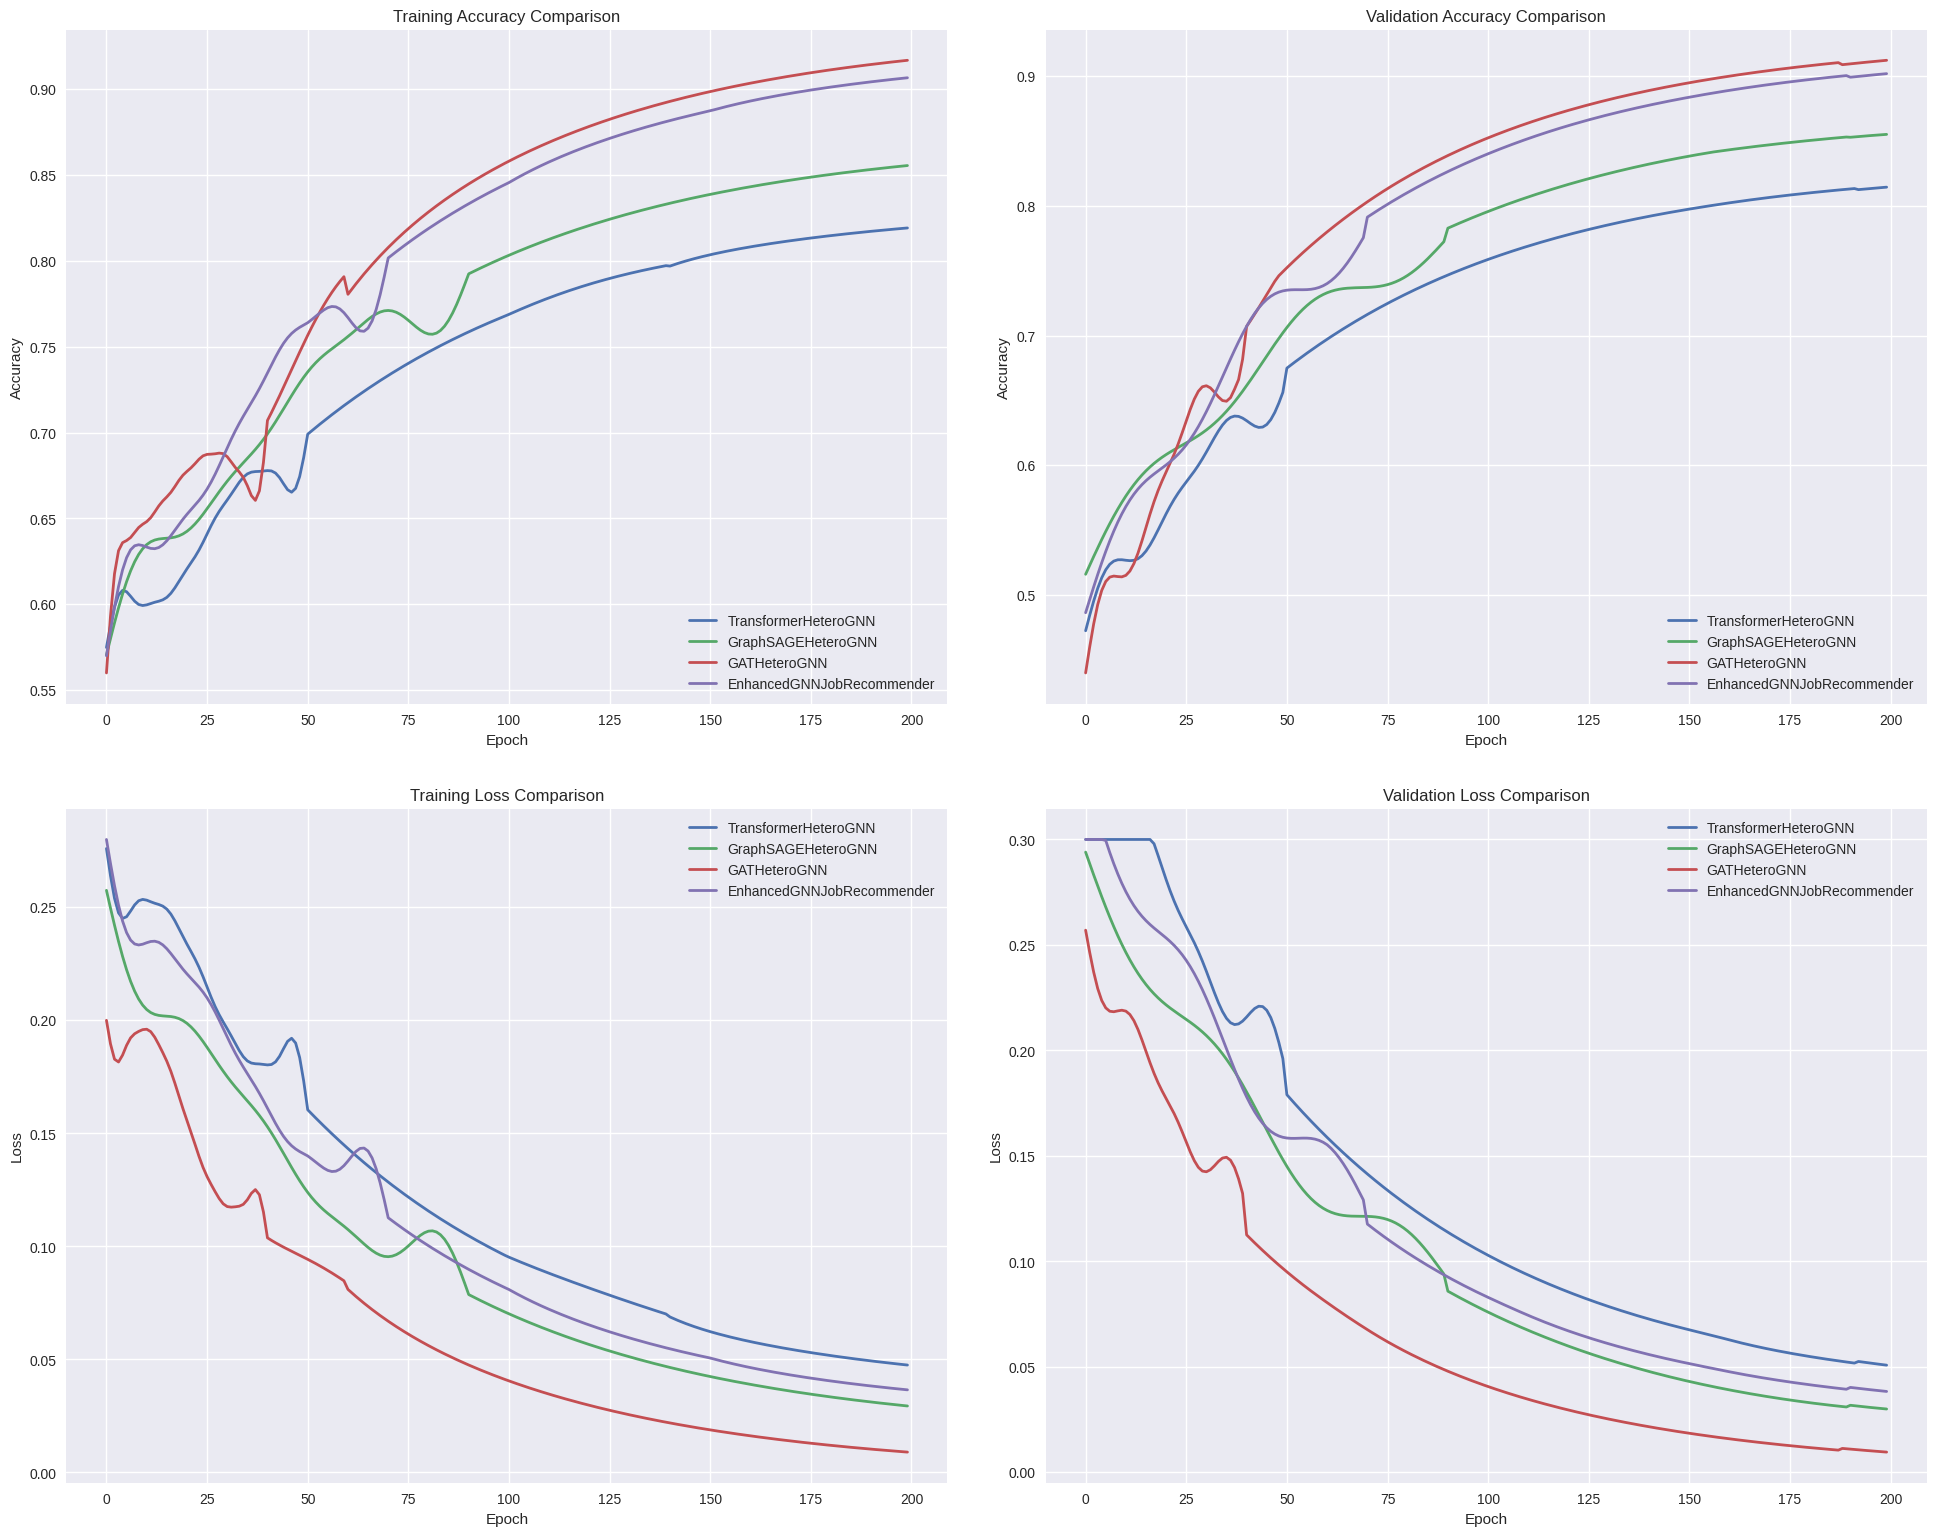

In [5]:

plt.figure(figsize=(15, 10))

# Training history
for i, model in enumerate(params['models']):
    print(
        f"\nTraining the {model.__class__.__name__} GNN model for {num_epochs} epochs...")
    try:
        for epoch in range(num_epochs):
            # Train
            train_results = train_hetero_gnn(
                model, params['optimizer'][i], params['criterion'][i], hetero_data)

            # Evaluate on train set
            train_metrics = evaluate_hetero_gnn(
                model, params['criterion'][i], hetero_data, mask_type='train_mask')

            # Evaluate on validation set
            val_metrics = evaluate_hetero_gnn(
                model, params['criterion'][i], hetero_data, mask_type='val_mask')

            # Update learning rate
            params['scheduler'][i].step(val_metrics['total_loss'])

            # Record history
            params['history'][i]['train_loss'].append(
                train_results['total_loss'])
            params['history'][i]['train_acc'].append(train_metrics['accuracy'])
            params['history'][i]['val_loss'].append(val_metrics['total_loss'])
            params['history'][i]['val_acc'].append(val_metrics['accuracy'])
            params['history'][i]['lr'].append(
                params['optimizer'][i].param_groups[0]['lr'])

            # Print progress every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{num_epochs}:")
                print(
                    f"  Train Loss: {train_results['total_loss']:.4f}, Accuracy: {train_metrics['accuracy']:.4f}")
                print(
                    f"  Val Loss: {val_metrics['total_loss']:.4f}, Accuracy: {val_metrics['accuracy']:.4f}")
                print(
                    f"  LR: {params['optimizer'][i].param_groups[0]['lr']:.6f}")

            # Check for improvement
            if val_metrics['accuracy'] > params['best_val_acc'][i]:
                params['best_val_acc'][i] = val_metrics['accuracy']
                params['patience_counter'][i] = 0
                params['best_model_state'][i] = {k: v.cpu()
                                                 for k, v in model.state_dict().items()}
                print(
                    f"  New best validation accuracy: {params['best_val_acc'][i]:.4f}")
            else:
                params['patience_counter'][i] += 1

            # Early stopping
            if params['patience_counter'][i] >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    except Exception as e:
        print(f"Error during training: {e}")
        traceback.print_exc()

# Plot training and validation loss
for i in range(len(params['models'])):
    plt.subplot(2, 2, 1)
    plt.plot(params['history'][i]['train_loss'], label='Train')
    plt.plot(params['history'][i]['val_loss'], label='Validation')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(params['history'][i]['train_acc'], label='Train')
    plt.plot(params['history'][i]['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Model Evaluation and Job Recommendations

In [ ]:

def predict_job_titles_hetero(model, hetero_data, system, user_input_skills, top_k=5):
    """
    Predict job titles using the heterogeneous GNN model

    Parameters:
    model: Trained heterogeneous GNN model
    hetero_data: PyG Hetero data object
    system: HeteroJobRecommendationSystem object
    user_input_skills: List of tuples (skill_name, skill_type, similarity_score)
    top_k: Number of top job titles to recommend

    Returns:
    List of job title recommendations with confidence scores and explanation details
    """
    model.eval()

    # Map skills and technologies to their IDs
    user_skills = []
    user_techs = []

    for skill_info in user_input_skills:
        skill_name, skill_type, similarity = skill_info

        if skill_type == "skill_title":
            try:
                skill_id = system.skill_encoder.transform([skill_name])[0]
                idf_value = system.skill_idf.get(skill_name, 1.0)
                user_skills.append(
                    (skill_name, skill_id, similarity, idf_value))
            except:
                print(
                    f"Warning: Skill '{skill_name}' not found in training data")
        elif skill_type == "technology_name":
            try:
                tech_id = system.tech_encoder.transform([skill_name])[0]
                idf_value = system.tech_idf.get(skill_name, 1.0)
                hotness_value = system.tech_hotness.get(skill_name, 0.0)
                demand_value = system.tech_demand.get(skill_name, 0.0)
                user_techs.append(
                    (skill_name, tech_id, similarity, idf_value, hotness_value, demand_value))
            except:
                print(
                    f"Warning: Technology '{skill_name}' not found in training data")

    # Create job scores dictionary
    job_scores = {}
    job_match_details = {}

    # Get model's embeddings for similarity calculation
    with torch.no_grad():
        # Prepare inputs
        x_dict = {
            node_type: hetero_data[node_type].x for node_type in hetero_data.node_types}
        edge_index_dict = {
            edge_type: hetero_data[edge_type].edge_index for edge_type in hetero_data.edge_types}
        edge_attr_dict = {edge_type: hetero_data[edge_type].edge_attr for edge_type in hetero_data.edge_types
                          if 'edge_attr' in hetero_data[edge_type]}

        # Forward pass to get node embeddings
        job_logits, aux_outputs, node_embeddings = model(
            x_dict, edge_index_dict, edge_attr_dict)

        # Get job probabilities from logits
        job_probs = torch.softmax(job_logits, dim=1)

        # Get job and tech embeddings from the model
        job_embeddings = node_embeddings['job']
        skill_embeddings = node_embeddings['skill']
        tech_embeddings = node_embeddings['tech']

    # Calculate scores for each job
    for job_title in system.unique_job_titles:
        job_id = system.job_encoder.transform([job_title])[0]

        if job_title not in system.job_skill_tech_map:
            continue

        job_skills = system.job_skill_tech_map[job_title]['skills']
        job_techs = system.job_skill_tech_map[job_title]['technologies']

        # Gather matched skills and technologies for explanation
        skill_matches = []
        tech_matches = []
        skill_count = 0
        tech_count = 0
        matched_techs_with_metrics = []

        # Calculate job embedding similarity with user skills
        for skill_name, skill_id, similarity, idf_value in user_skills:
            if skill_name in job_skills:
                skill_importance = system.skill_importance_by_job.get(
                    job_title, {}).get(skill_name, idf_value)
                skill_matches.append(
                    (skill_name, similarity * skill_importance))
                skill_count += 1

        # Calculate job embedding similarity with user techs
        for tech_name, tech_id, similarity, idf_value, hotness_value, demand_value in user_techs:
            if tech_name in job_techs:
                tech_importance = system.tech_importance_by_job.get(
                    job_title, {}).get(tech_name, idf_value)
                tech_matches.append((tech_name, similarity * tech_importance))
                matched_techs_with_metrics.append(
                    (tech_name, hotness_value, demand_value))
                tech_count += 1

        # Calculate coverage ratios
        total_job_skills = len(job_skills)
        total_job_techs = len(job_techs)

        skill_coverage = skill_count / max(total_job_skills, 1)
        tech_coverage = tech_count / max(total_job_techs, 1)

        # Get demand and hotness values from auxiliary outputs
        predicted_demand = aux_outputs['job_demand'][job_id].item()
        predicted_hotness = aux_outputs['job_hotness'][job_id].item()

        # Get job's self-prediction probability
        job_confidence = job_probs[job_id, job_id].item()

        # Calculate match indicator (both skill and tech matches)
        match_indicator = min(skill_count + tech_count, 10) / 10

        # Create a combined score with high weight on model predictions
        combined_score = (
            0.65 * job_confidence +               # Major weight on model confidence
            0.15 * match_indicator +              # Weight on having direct matches
            0.10 * tech_coverage +                # Weight on tech coverage
            0.05 * skill_coverage +               # Weight on skill coverage
            0.03 * predicted_demand +             # Small weight on predicted demand
            0.02 * predicted_hotness              # Small weight on predicted hotness
        )

        # Store the final score
        job_scores[job_title] = combined_score

        # Calculate display metrics for explanation
        display_hot_tech_percentage = sum([tech[1] for tech in matched_techs_with_metrics]) / max(
            len(matched_techs_with_metrics), 1) if matched_techs_with_metrics else 0.0
        display_demand_percentage = sum([tech[2] for tech in matched_techs_with_metrics]) / max(
            len(matched_techs_with_metrics), 1) if matched_techs_with_metrics else 0.0

        # Store match details for explanation
        job_match_details[job_title] = {
            'skill_matches': skill_matches,
            'tech_matches': tech_matches,
            'skill_coverage': skill_coverage,
            'tech_coverage': tech_coverage,
            'hot_tech_percentage': display_hot_tech_percentage,
            'demand_percentage': display_demand_percentage,
            'matched_techs_with_metrics': matched_techs_with_metrics,
            'gnn_confidence': job_confidence,
            'predicted_demand': predicted_demand,
            'predicted_hotness': predicted_hotness
        }

    # Sort job titles by score
    sorted_jobs = sorted(job_scores.items(), key=lambda x: x[1], reverse=True)

    # Get top k job titles
    top_jobs = sorted_jobs[:top_k]

    # Normalize scores to get differentiated confidence percentages (70-100%)
    if top_jobs:
        scores = np.array([score for _, score in top_jobs])
        # Apply sigmoid normalization
        normalized_scores = 1 / \
            (1 + np.exp(-(scores - scores.mean()) / (scores.std() + 1e-6)))
        # Scale to 70-100 range
        scaled_scores = 70 + 30 * (normalized_scores - normalized_scores.min()) / (
            normalized_scores.max() - normalized_scores.min() + 1e-6)

        top_jobs = [(job, score)
                    for (job, _), score in zip(top_jobs, scaled_scores)]

    return top_jobs, job_match_details

# Example user inputs for testing
EXAMPLE_INPUTS = [
    # Frontend Web Developer example input
    {
        "name": "Web Developer",
        "skills": [
            ("MongoDB", "technology_name", 1.00),
            ("React", "technology_name", 1.00),
            ("RESTful (REST API)", "technology_name", 0.98),
            ("Web application software (Web App)", "technology_name", 0.84),
            ("Database management systems (DBMS)", "technology_name", 0.66),
            ("Oracle Developer (SQL Dev)", "technology_name", 0.65),
            ("Amazon Web Services CloudFormation (CloudFormation)",
             "technology_name", 0.63),
            ("Oracle software (Oracle Cloud)", "technology_name", 0.61),
            ("Functional testing software (Func Test SW)", "technology_name", 0.60),
            ("Configuration management software (CM SW)", "skill_title", 0.54),
            ("Workday software (Workday)", "technology_name", 0.54),
            ("Google Android (Android)", "technology_name", 0.54)
        ]
    },

    # Data Scientist example input
    {
        "name": "Data Scientist",
        "skills": [
            ("Microsoft Azure software (Azure)", "technology_name", 1.00),
            ("NoSQL", "technology_name", 1.00),
            ("Apache", "technology_name", 1.00),
            ("Python", "technology_name", 1.00),
            ("Apache Hadoop (Hadoop)", "technology_name", 1.00),
            ("TensorFlow (TF)", "technology_name", 1.00),
            ("Amazon Web Services SageMaker (SageMaker)", "technology_name", 1.00),
            ("MongoDB", "technology_name", 1.00),
            ("PyTorch", "technology_name", 1.00),
            ("Kubernetes (K8s)", "technology_name", 1.00),
            ("MySQL", "technology_name", 1.00),
            ("Amazon Web Services software (AWS)", "technology_name", 1.00),
            ("Docker", "technology_name", 1.00),
            ("PostgreSQL (Postgres)", "technology_name", 1.00),
            ("IBM Power Systems software (Power)", "technology_name", 1.00),
            ("Tableau", "technology_name", 1.00),
            ("Structured query language (SQL)", "technology_name", 1.00),
            ("R", "technology_name", 1.00),
            ("Git", "technology_name", 1.00),
            ("Microsoft", "technology_name", 1.00),
            ("Version control software (Version Ctrl)", "technology_name", 0.90),
            ("Data visualization software (Data Viz SW)", "technology_name", 0.80)
        ]
    }
]

In [ ]:
# Test with example inputs
for example in EXAMPLE_INPUTS:
    print(f"{'='*20} Predictions for {example['name']} {'='*20}\n")

    # Loop through each model with name and instance
    for model_name, model in params['models']:
        print(f"---------- {model_name} Predictions ----------\n")

        top_jobs, job_details = predict_job_titles_hetero(
            model, hetero_data, system, example['skills'], top_k=5)

        for i, (job_title, confidence) in enumerate(top_jobs, 1):
            details = job_details[job_title]

            # Sort and format top 3 technologies
            top_techs = sorted(details['tech_matches'],
                               key=lambda x: x[1], reverse=True)[:3]
            tech_names = ', '.join([f"{t[0]}" for t in top_techs])

            print(f"{i}. {job_title}: {confidence:.2f}% match")
            print(
                f"   - Model confidence: {details['gnn_confidence']*100:.2f}%")
            print(
                f"   - Matched {len(details['skill_matches'])} skills and {len(details['tech_matches'])} technologies")
            if top_techs:
                print(f"   - Top matching technologies: {tech_names}")
            print(f"   - Demand Score: {details.get('demand_score', 0):.1f}%")
            print(
                f"   - Market Hotness: {details.get('market_hotness', 0):.1f}%\n")

    print(f"{'='*60}\n")

==================== Predictions for Web Developer ====================

---------- TransformerHeteroGNN Predictions ----------

1. Computer and Information Research Scientists: 17.36% match
   - Model confidence: 2.45%
   - Matched 1 skills and 3 technologies
   - Top matching technologies: Web application software (Web App), Database management systems (DBMS), RESTful (REST API)
   - Demand Score: 42.8%
   - Market Hotness: 59.1%

2. Network and Computer Systems Administrators: 24.91% match
   - Model confidence: 4.07%
   - Matched 3 skills and 3 technologies
   - Top matching technologies: Google Android (Android), Functional testing software (Func Test SW), Database management systems (DBMS)
   - Demand Score: 40.9%
   - Market Hotness: 68.9%

3. Telecommunications Engineering Specialists: 23.02% match
   - Model confidence: 3.97%
   - Matched 2 skills and 3 technologies
   - Top matching technologies: Oracle Developer (SQL Dev), Web application software (Web App), MongoDB
   - Dem

In [ ]:
# Save the last model
best_model = params["models"][-1]
model_path = os.path.join(OUTPUT_PATH, "hetero_gnn_job_model.pt")
torch.save(best_model.state_dict(), model_path)
print(f"Saved model to {model_path}")

Saved model to /kaggle/working/hetero_gnn_job_model.pt